In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
from mtrain.smallnet.tfms import resize_and_pad_raw, unpad_and_resize_mask
from mtrain.smallnet.unet.predict import overlay_mask_on_img
import cv2
from fastai.vision.all import load_learner
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random


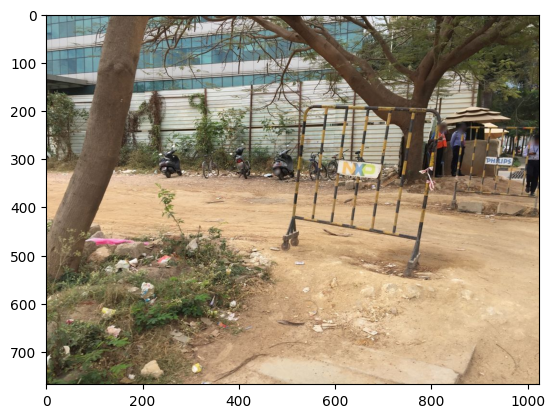

In [114]:
f = "/Users/hariomnarang/Downloads/local-files.jpeg"
img = cv2.imread(f)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [115]:
EXP_BASE = Path("/Users/hariomnarang/Desktop/gdrive-sync/garbage/experiments")
sz100 = EXP_BASE / "T012s-unet-small-ds-test-DATA_COUNT=2000-TILE_SIZE=100-BATCH_SIZE=16-FINE_TUNE_EPOCHS=20-FIT_EPOCHS=10"
sz50 = EXP_BASE / "T012s-unet-small-ds-test-DATA_COUNT=2000-TILE_SIZE=50-BATCH_SIZE=16-FINE_TUNE_EPOCHS=20-FIT_EPOCHS=10"
sz30 = EXP_BASE / "T012s-unet-small-ds-test-DATA_COUNT=2000-TILE_SIZE=30-BATCH_SIZE=16-FINE_TUNE_EPOCHS=20-FIT_EPOCHS=10"
learn = load_learner(sz50 / "log" / "export.pkl")

/Users/hariomnarang/Desktop/personal/roads/mtrain/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


# Single object resize or no

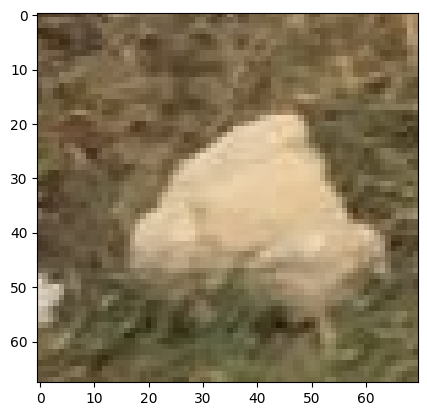

In [116]:
crop = img[700:800, 180:250]
plt.imshow(crop)

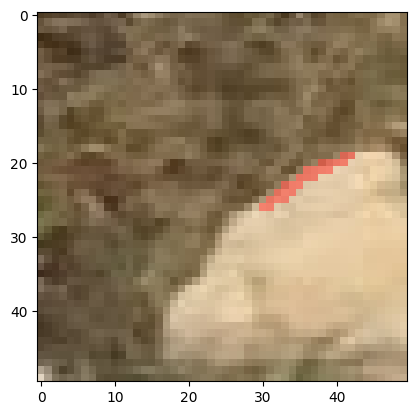

In [112]:
# without prepadding only do 50x50
crop_50 = crop[:50, :50]
mask, _, _ = learn.predict(crop_50)
mask = mask.numpy().astype(bool)
plt.imshow(overlay_mask_on_img(crop_50, mask, 0.4))

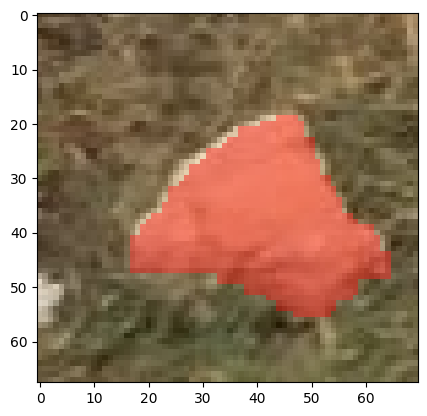

In [113]:
# take a bigger crop and resize first
padded, meta = resize_and_pad_raw(crop, 50)
mask, _, _ = learn.predict(padded)
mask = mask.numpy()
unpadded_mask = unpad_and_resize_mask(mask, meta)
unpadded_mask = unpadded_mask.astype(bool)
plt.imshow(overlay_mask_on_img(crop, unpadded_mask, 0.4))

For single objects, coming down from a bigger size to 50 seems profitable, lets try the same function on a bigger crop.  

In [123]:
def resize_and_pred(learn, crop):
    padded, meta = resize_and_pad_raw(crop, 50)
    mask, _, _ = learn.predict(padded)
    mask = mask.numpy()
    unpadded_mask = unpad_and_resize_mask(mask, meta)
    unpadded_mask = unpadded_mask.astype(bool)
    return overlay_mask_on_img(crop, unpadded_mask, 0.4)

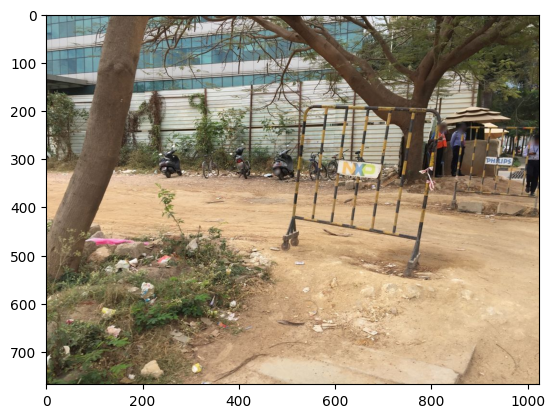

In [124]:
plt.imshow(img)

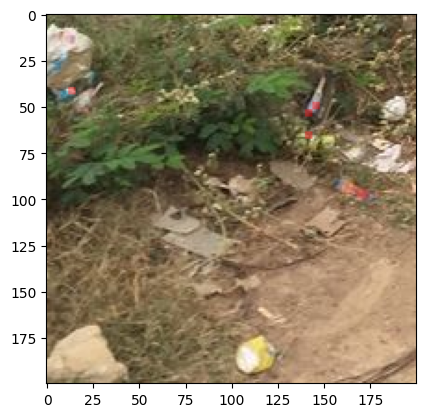

In [126]:
# bigger crop
crop = img[550:750, 200:400]
plt.imshow(resize_and_pred(learn, crop))

its missing a lot of stuff in 200x200, lets go further down.  in multiple tiles

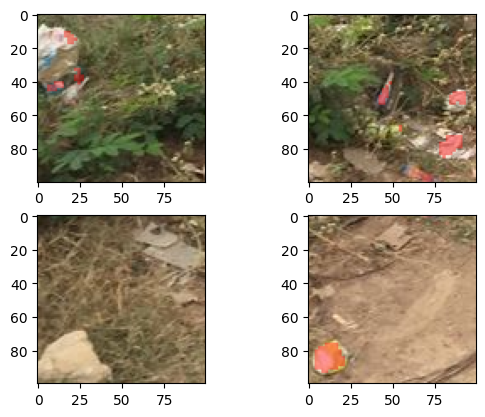

In [130]:
from mtrain.smallnet.tile import split_image_into_tiles

# this is slightly better
tiles = split_image_into_tiles(crop, 100)
res = [resize_and_pred(learn, t[0]) for t in tiles]

_, ax = plt.subplots(2,2)
ax = ax.flatten()
for i in range(4):
    ax[i].imshow(res[i])
plt.show()

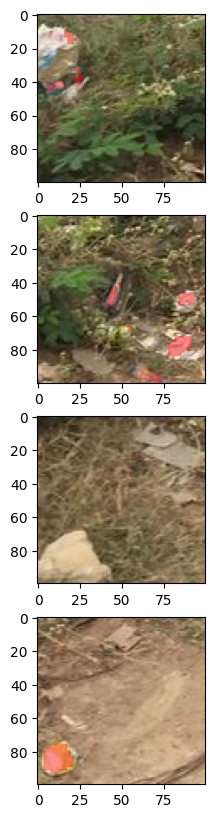

In [140]:
# this is slightly better
tiles = split_image_into_tiles(crop, 100)
res = [resize_and_pred(learn, t[0]) for t in tiles]

_, ax = plt.subplots(len(res),1, figsize=(30,10))
ax = ax.flatten()
for i in range(len(res)):
    ax[i].imshow(res[i])
plt.show()

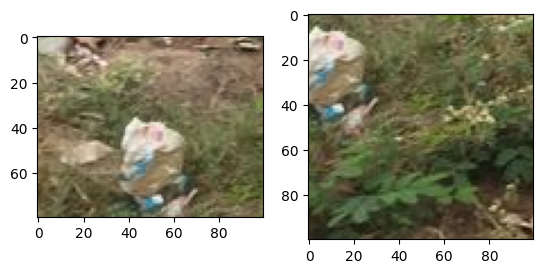

In [154]:
# its not catching some images, is it because they are on the side?
# lets see why its not working on tiles[0]
# crop = img[550:750, 200:400]
# crop was taken from the above, code, the actual crop is 
# lets try to centre the piece of garbage

actual_tile = img[550:650, 200:300]
centered_tile = img[520:600, 160:260]
_, ax = plt.subplots(1,2)
ax[0].imshow(centered_tile)
ax[1].imshow(actual_tile)


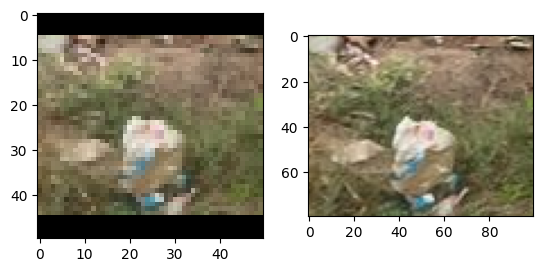

In [155]:
# lets run on centered tile

padded, _ = resize_and_pad_raw(centered_tile, 50)
_, ax = plt.subplots(1, 2)
ax[0].imshow(padded)
ax[1].imshow(centered_tile)

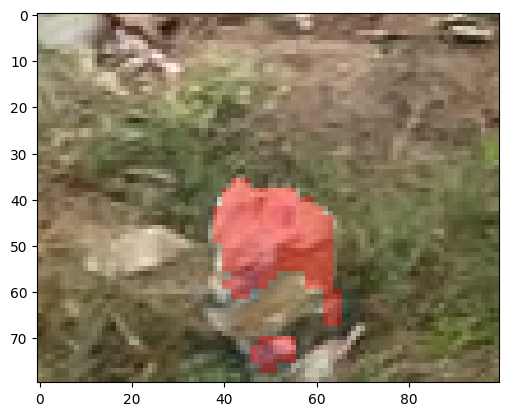

In [ ]:
# and this works
# the model has problems with centering
plt.imshow(resize_and_pred(learn, centered_tile))

# Multiple garbage pieces

Lets do multiple pieces, first thing we ll do is make sure they are centered

## 2 pieces

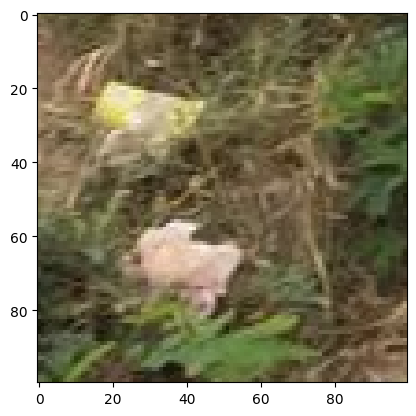

In [160]:
# 2 pieces, centered
tile = img[590:690, 100:200]
plt.imshow(tile)

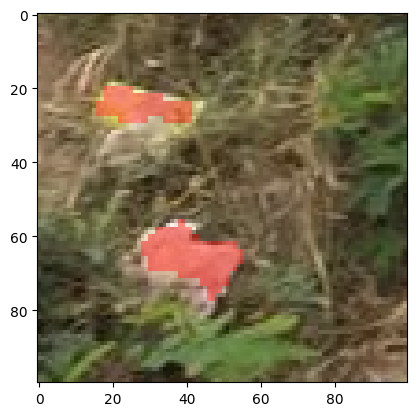

In [162]:
# and it works
plt.imshow(resize_and_pred(learn, tile))

## more than 2

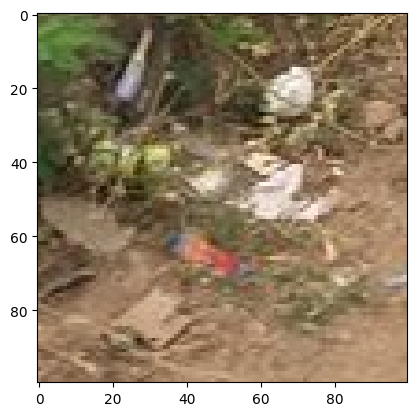

In [170]:
plt.imshow(img[580:680, 320:420])

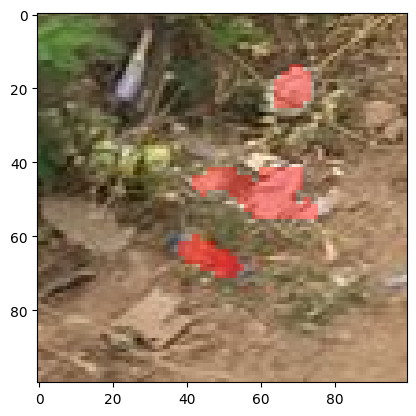

In [171]:
# works only on two pieces i feel, its not picking up all three
tile= img[580:680, 320:420]
# tile = img[450:550, 120:220]
plt.imshow(resize_and_pred(learn, tile))

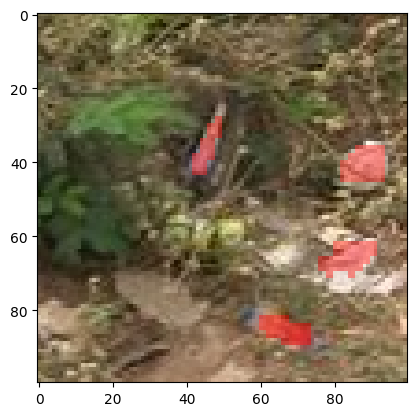

In [177]:
# lets do for the same image and center the yellow piece of garbage
tile= img[560:660, 300:400]
plt.imshow(resize_and_pred(learn, tile))

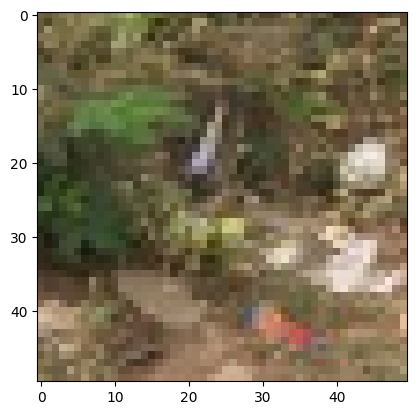

In [179]:
# it is not picking the yellow tile at all, lets look at the resized stuff
plt.imshow(resize_and_pad_raw(tile, 50)[0])


It does seem to get multiple centered pieces of garbage also, will prepare the dataset with uncentered stuff